In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import os
import time

In [2]:
!nvidia-smi

Fri Nov 10 16:14:21 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:17:00.0 Off |                    0 |
| N/A   27C    P0              44W / 250W |  13744MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
# Check the number of GPUs available
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

Number of GPUs available: 1


In [4]:
# # import npy file
# input_data = np.load('./Physics-based data/aradhya_data/input_data_pickled.pkl', allow_pickle=True)
# output_data= np.load('./Physics-based data/aradhya_data/output_data_pickled.pkl', allow_pickle=True)

In [5]:
input_data = np.load('/scratch/amath12/new_input_data_pickled.pkl', allow_pickle=True)
output_data= np.load('/scratch/amath12/new_output_data_pickled.pkl', allow_pickle=True)

print(input_data.shape, output_data.shape)

(1360, 256, 256) (1360, 256, 256)


In [6]:
# unsqueeze the data
input_data = np.expand_dims(input_data, axis=1)
output_data = np.expand_dims(output_data, axis=1)   

print(input_data.shape, output_data.shape)

(1360, 1, 256, 256) (1360, 1, 256, 256)


In [7]:
# make dataloader
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

# convert to tensor
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# create dataloader
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [8]:

def downsample(input_channels, output_channels, kernel_size, apply_batchnorm=True, dropout_prob=0.0, weight_mean=0, weight_sd=0.02):
    layers = [nn.Conv2d(input_channels, output_channels, kernel_size, stride=2, padding=1, bias=False)]
    
    # Initialize the weights with mean and standard deviation
    nn.init.normal_(layers[0].weight, mean=weight_mean, std=weight_sd)
    
    if apply_batchnorm:
        layers.append(nn.BatchNorm2d(output_channels))
    layers.append(nn.LeakyReLU(0.2))
    
    if dropout_prob > 0.0:
        layers.append(nn.Dropout(dropout_prob))
    
    return nn.Sequential(*layers)

def upsample(input_channels, output_channels, kernel_size, apply_batchnorm=True, dropout_prob=0.0, weight_mean=0, weight_sd=0.02):
    layers = [nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=2, padding=1, bias=False)]
    
    # Initialize the weights with mean and standard deviation
    nn.init.normal_(layers[0].weight, mean=weight_mean, std=weight_sd)
    
    if apply_batchnorm:
        layers.append(nn.BatchNorm2d(output_channels))
    layers.append(nn.ReLU())
    
    if dropout_prob > 0.0:
        layers.append(nn.Dropout(dropout_prob))
    
    return nn.Sequential(*layers)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Define the downsample layers
        self.conv_layers = nn.ModuleList([
            downsample(1, 64, 4),
            downsample(64, 128, 4),
            downsample(128, 256, 4, dropout_prob=0.5),
            downsample(256, 512, 4),
            downsample(512, 512, 4),
            downsample(512, 512, 4),
            downsample(512, 512, 4),
            downsample(512, 512, 4)
        ])

        # Define the upsample layers
        self.up_layers = nn.ModuleList([
            upsample(512, 512, 4),
            upsample(1024, 512, 4),
            upsample(1024, 512, 4),
            upsample(1024, 512, 4),
            upsample(1024, 256, 4),
            upsample(512, 128, 4),
            upsample(256, 64, 4)
        ])

        # Final convolutional layer for generating the output
        self.last = nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1)

    def forward(self, x):
        # Downsampling through the model
        skips = []
        for layer in self.conv_layers:
            x = layer(x)
            skips.append(x)
        
        skips = skips[:-1]

        # Upsampling and establishing skip connections
        for layer, skip in zip(self.up_layers, reversed(skips)):
            x = layer(x)
            x = torch.cat([x, skip], dim=1)

        x = self.last(x)

        return x

# Instantiate the Generator model
generator = Generator()


In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Discriminator, self).__init__()
        
        # The first few convolutional layers using the downsample block
        self.downsample1 = downsample(input_channels * 2, 64,4, apply_batchnorm=False)
        self.downsample2 = downsample(64, 128,4)
        self.downsample3 = downsample(128, 256,4)
        
        # Continue with the remaining convolutional layers
        self.conv4 = nn.Conv2d(256, 512, 4, stride=1, padding=0)  # No padding here
        self.conv5 = nn.Conv2d(512, 1, 4, stride=1, padding=0)
        
        # Batch normalization layer
        self.batchnorm1 = nn.BatchNorm2d(512)
        
        # Activation function
        self.leaky_relu = nn.LeakyReLU(0.2)
        
    def forward(self, input_image, target_image):
        # Concatenate input and target images along the channel dimension
        x = torch.cat((input_image, target_image), dim=1)
        x = self.downsample1(x)
        x = self.downsample2(x)
        x = self.downsample3(x)
        x = nn.ZeroPad2d((1, 1, 1, 1))(x)
        
        # Continue with the remaining convolutional layers
        x = self.conv4(x)
        x = self.batchnorm1(x)
        x = self.leaky_relu(x)
        x = nn.ZeroPad2d((1, 1, 1, 1))(x)
        x = self.conv5(x)
        
        return x

# Define the number of input and output channels (adjust according to your needs)
input_channels = 1  # Adjust this based on your actual input channels
output_channels = 1  # Adjust this based on your actual output channels

# Instantiate the Discriminator model
discriminator = Discriminator(input_channels, output_channels)


## Loss objectives

### 1. Generator

In [10]:
LAMBDA = 100

# Define the Binary Cross Entropy loss
loss_object = nn.BCEWithLogitsLoss()

def generator_loss(disc_generated_output, gen_output, target):
    # Compute GAN loss
    gan_loss = loss_object(disc_generated_output, torch.ones_like(disc_generated_output))

    # Compute L1 loss
    l1_loss = F.mse_loss(target, gen_output)

    # Calculate the total generator loss
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

### 2. Discriminator

In [11]:
def discriminator_loss(disc_real_output, disc_generated_output):
    # Compute the loss for real and generated images
    real_loss = loss_object(disc_real_output, torch.ones_like(disc_real_output))
    generated_loss = loss_object(disc_generated_output, torch.zeros_like(disc_generated_output))

    # Calculate the total discriminator loss
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

# Define Optimizers

In [12]:
learning_rate = 2e-4
beta_1 = 0.5

generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Training Loop

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

generator.to(device)
discriminator.to(device)

Discriminator(
  (downsample1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (downsample2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (downsample3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
)

In [14]:
start_time = time.time()
num_epochs = 300
num_batches = len(train_loader)

gen_losses=[]
disc_losses=[]

# mse
mse_loss = torch.nn.MSELoss()

iter=0
for epoch in range(num_epochs):
    for batch_idx,(input_image, target) in enumerate(train_loader):
        # Transfer to GPU
        input_image = input_image.to(device)
        target = target.to(device)

        # Generator forward pass
        gen_output = generator(input_image)

        # Discriminator forward pass with real and generated images
        disc_real_output = discriminator(input_image, target)
        disc_generated_output = discriminator(input_image, gen_output.detach())

        # Generator loss calculation
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)

        # Update generator
        generator_optimizer.zero_grad()  # Zero the gradients for the generator
        gen_total_loss.backward()       # Calculate gradients for the generator
        generator_optimizer.step()      # Update the generator's weights

        # Discriminator loss calculation
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output.detach())

        # Update discriminator
        discriminator_optimizer.zero_grad()  # Zero the gradients for the discriminator
        disc_loss.backward()                 # Calculate gradients for the discriminator
        discriminator_optimizer.step()       # Update the discriminator's weights

        # Record the losses for monitoring
        gen_losses.append(gen_total_loss.item())
        disc_losses.append(disc_loss.item())

        iter+=1

        if iter%100==0:
            
            print('Epoch: {}, Iteration: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch, iter, gen_total_loss, disc_loss))
            
            generator.eval()  # Set the generator to evaluation mode
            with torch.no_grad():  # No gradients needed for evaluation
                test_mse = 0.0
                test_samples = 0
                
                for input_image, target in test_loader:
                    # Transfer to GPU
                    input_image = input_image.to(device)
                    target = target.to(device)
                    
                    # Generate the output using the generator for the current batch
                    gen_output = generator(input_image)
                    
                    # Calculate and accumulate MSE loss
                    test_mse += mse_loss(gen_output, target).item() * target.size(0)
                    test_samples += target.size(0)
                
                # Compute the average MSE over the test set
                test_mse /= test_samples
            
            print(f'Epoch {epoch}: Average MSE on Test Set: {test_mse}')
            generator.train()  # Set the generator back to training mode

    

Epoch: 2, Iteration: 100, Generator Loss: 3.137667655944824, Discriminator Loss: 8.220963478088379
Epoch 2: Average MSE on Test Set: 0.2341007905847886
Epoch: 5, Iteration: 200, Generator Loss: 1.9018981456756592, Discriminator Loss: 8.714742660522461
Epoch 5: Average MSE on Test Set: 0.03073819222695687
Epoch: 8, Iteration: 300, Generator Loss: 1.1826286315917969, Discriminator Loss: 8.949602127075195
Epoch 8: Average MSE on Test Set: 0.015351078199113117
Epoch: 11, Iteration: 400, Generator Loss: 0.9706389307975769, Discriminator Loss: 9.318674087524414
Epoch 11: Average MSE on Test Set: 0.007506343152593164
Epoch: 14, Iteration: 500, Generator Loss: 0.8428349494934082, Discriminator Loss: 9.651395797729492
Epoch 14: Average MSE on Test Set: 0.0060297467964975275
Epoch: 17, Iteration: 600, Generator Loss: 0.8297948837280273, Discriminator Loss: 9.804877281188965
Epoch 17: Average MSE on Test Set: 0.006004942690624911
Epoch: 20, Iteration: 700, Generator Loss: 1.0338629484176636, Disc

In [15]:
end_time = time.time()
training_time = end_time - start_time
# Print the training time
print(f"Training Time for cGAN: {training_time} seconds")

Training Time for cGAN: 665.5833427906036 seconds


In [16]:
torch.save(generator.state_dict(), 'pytorch_pix2pix_generator.pth')
torch.save(discriminator.state_dict(), 'pytorch_pix2pix_discriminator.pth')

# torch.save(generator, 'pytorch_pix2pix_generator.pth')
# torch.save(discriminator, 'pytorch_pix2pix_discriminator.pth')

In [17]:
def generate_images( test_input, tar, prediction):
  plt.figure(figsize=(15, 15))
  display_list = [test_input, tar, prediction]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5, cmap='jet')
    plt.axis('off')
  plt.show()

def generate_images_samescale(test_input, tar, prediction):
  '''
  ensures the target and predicted are on the same color scale
  '''

  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  global_min = min([np.min(img) for img in [tar[0], prediction[0]]])
  global_max = max([np.max(img) for img in [tar[0], prediction[0]]])

  plt.subplot(1, 3, 1)
  plt.title(title[0])
  plt.imshow(test_input, cmap='jet')
  plt.axis('off')
  plt.subplot(1, 3, 2)
  plt.title(title[1])
  plt.imshow(tar, cmap='jet', vmin=global_min, vmax=global_max)
  plt.axis('off')
  plt.subplot(1, 3, 3)
  plt.title(title[2])
  plt.imshow(prediction, cmap='jet', vmin=global_min, vmax=global_max)
  plt.axis('off')  
  # for i in range(3):
  #   plt.subplot(1, 3, i+1)
  #   plt.title(title[i])
  #   # Getting the pixel values in the [0, 1] range to plot.
  #   #plt.imshow(display_list[i] * 0.5 + 0.5, cmap='jet')
  #   plt.imshow(display_list[i], cmap='jet', vmin=global_min, vmax=global_max)
  #   #plt.colorbar()
  #   plt.axis('off')
  plt.show()

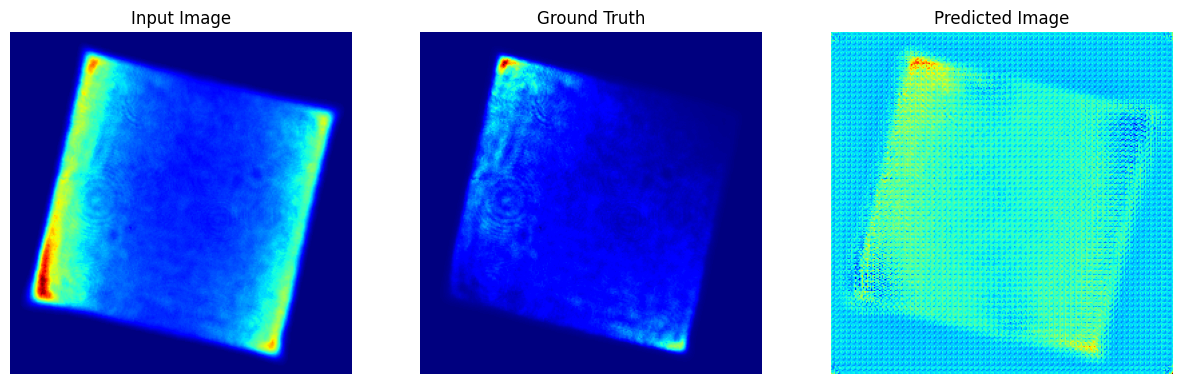

Generator(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.5, inplace=False)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine

In [18]:
image_index = 10

# Switch the generator to evaluation mode
generator.eval()

# # Get a batch of test inputs and targets
# test_input, tar = next(iter(test_loader))

# # Transfer them to the same device as your model
# test_input, tar = test_input.to(device), tar.to(device)

test_input = X_test[image_index].unsqueeze(1).to(device)

# Generate predictions
with torch.no_grad():  # No gradients required for generating predictions
    prediction = generator(test_input)

# # Move tensors back to CPU for visualization if they are on GPU
# test_input, tar, prediction = test_input.cpu(), tar.cpu(), prediction.cpu()

# Assuming the images are single-channel (grayscale) and are currently in [C, H, W] format,
# you need to use `squeeze()` to remove the channel dimension if C=1 for plotting
# test_input = test_input.squeeze(1)
# tar = tar.squeeze(1)
test_input = X_test[image_index].squeeze(1)
tar = y_test[image_index].squeeze(1)
prediction = prediction.squeeze(1)

# Use the utility function to display the images
# If images are in tensors, convert them to numpy for matplotlib
generate_images(test_input[0].numpy(), tar[0].numpy(), prediction[0].cpu().numpy())

# Switch the generator back to training mode if you have more training to do
generator.train()

Top 3 Predictions


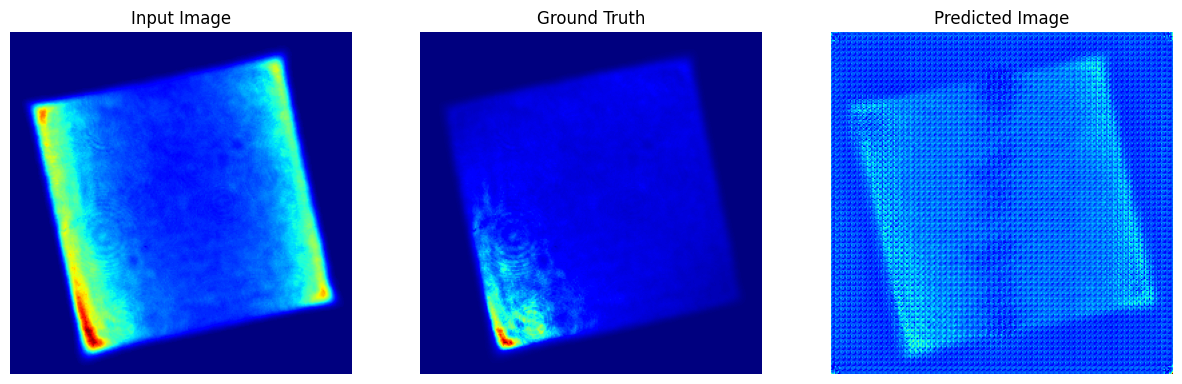

MSE for image 111: 1.7079844838008285e-05


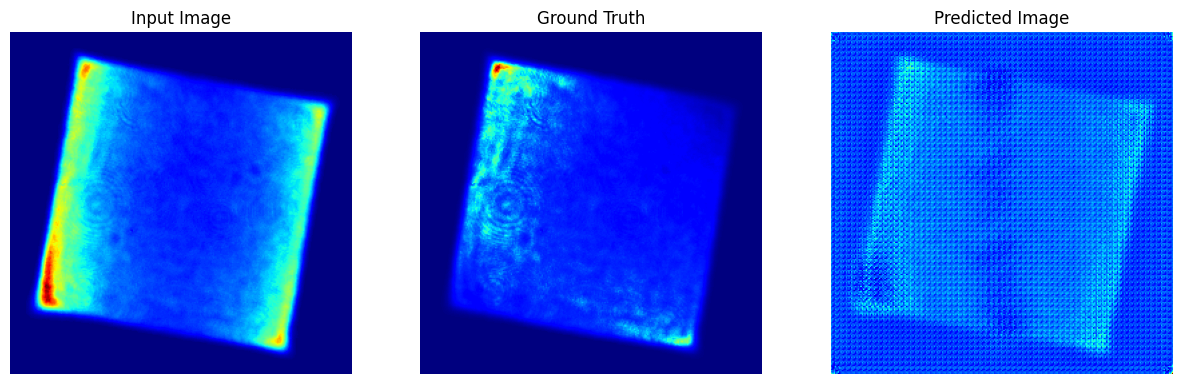

MSE for image 152: 1.718316343612969e-05


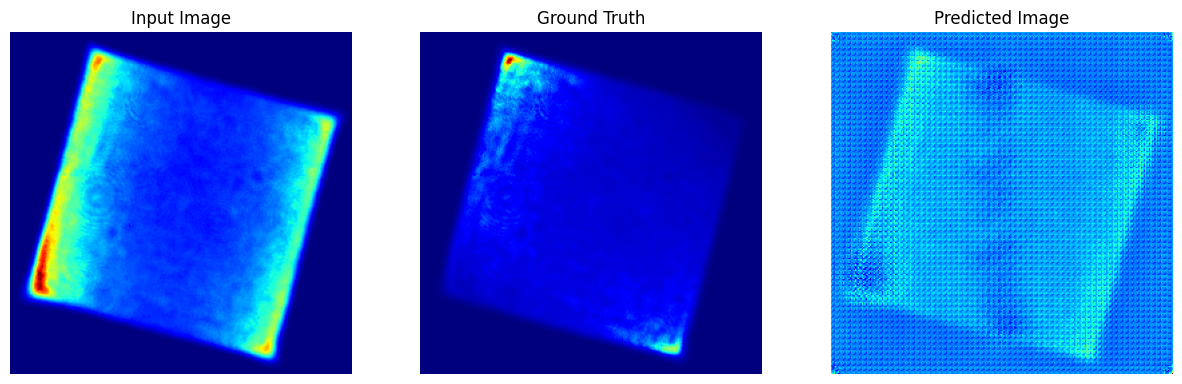

MSE for image 256: 1.719651118037291e-05

Bottom 3 Predictions


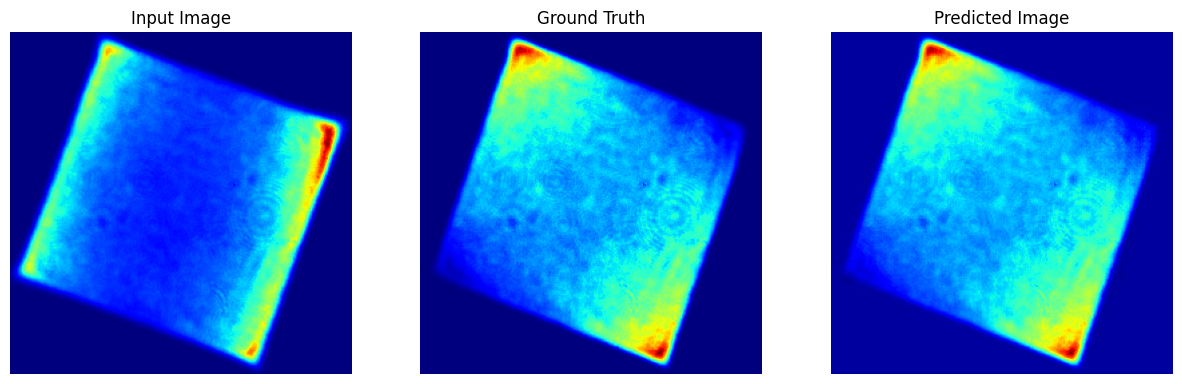

MSE for image 85: 0.0016127097187563777


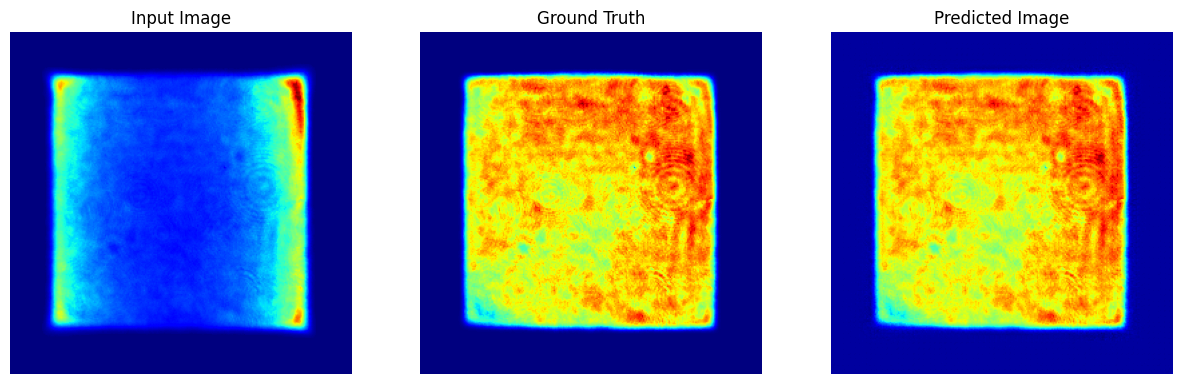

MSE for image 262: 0.0015329577727243304


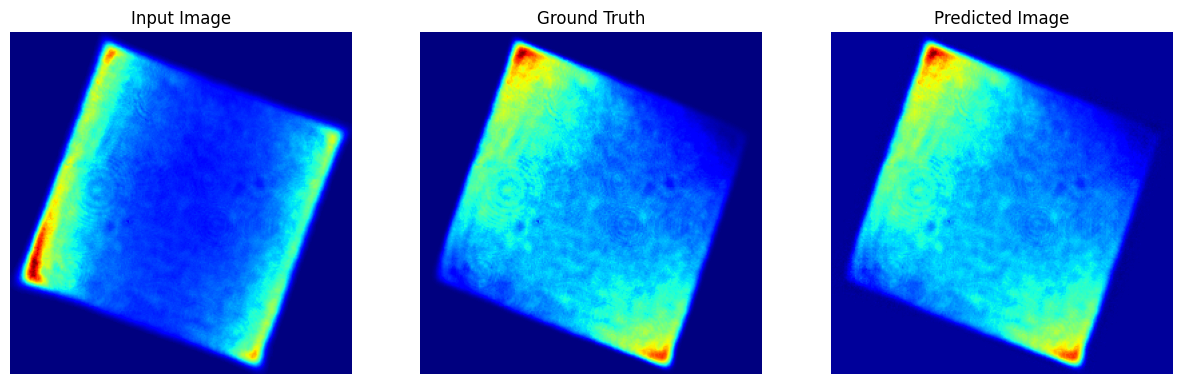

MSE for image 173: 0.0014925284776836634


Generator(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.5, inplace=False)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine

In [19]:
from torch.nn.functional import mse_loss

# Switch the generator to evaluation mode
generator.eval()

# Calculate MSE for each item in the test set
mse_scores = []
for index in range(len(X_test)):
    test_input = X_test[index].unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        prediction = generator(test_input)
    mse_scores.append(mse_loss(prediction, y_test[index].unsqueeze(0).to(device)).item())

# Get indices of top 3 and bottom 3 MSE scores
top_indices = sorted(range(len(mse_scores)), key=lambda i: mse_scores[i])[:3]
bottom_indices = sorted(range(len(mse_scores)), key=lambda i: mse_scores[i], reverse=True)[:3]

# Define a function to plot images
def plot_images(indices, title):
    for image_index in indices:
        test_input = X_test[image_index].unsqueeze(0).to(device)  # Add batch dimension
        tar = y_test[image_index].unsqueeze(0).to(device)
        with torch.no_grad():
            prediction = generator(test_input).cpu().squeeze()  # Generate prediction and move to CPU
        test_input = X_test[image_index].cpu().squeeze(0)  # Move input to CPU
        tar = y_test[image_index].cpu().squeeze(0)  # Move target to CPU

        generate_images(test_input.numpy(), tar.numpy(), prediction.numpy())
        print(f"MSE for image {image_index}: {mse_scores[image_index]}")

# Plot top 3 images
print("Top 3 Predictions")
plot_images(top_indices, "Top 3 Predictions")

# Plot bottom 3 images
print("\nBottom 3 Predictions")
plot_images(bottom_indices, "Bottom 3 Predictions")

# Switch the generator back to training mode if you have more training to do
generator.train()

In [20]:
test_output = y_test[top_indices[0]].squeeze().numpy()
np.mean(test_output)

0.0005897038

In [21]:
test_output = y_test[bottom_indices[0]].squeeze().numpy()
np.mean(test_output)

1.1443137

In [22]:
# release GPU memory
torch.cuda.empty_cache()

In [23]:
# convert X_test, y_test,output_test to numpy
X_test_nmp = X_test.cpu().detach().numpy()
y_test_nmp = y_test.cpu().detach().numpy()

# generate images
generator.eval()
output_test = generator(X_test.to(device))
output_test_nmp = output_test.cpu().detach().numpy()

# delete gpu cache
del output_test
torch.cuda.empty_cache()

In [24]:
# train loader without shuffle
train_loader_1 = DataLoader(train_data, batch_size=batch_size, shuffle=False)

X_train_nmp = X_train.cpu().detach().numpy()
y_train_nmp = y_train.cpu().detach().numpy()

output_train=[]

# generate images
generator.eval()

for (data, target) in train_loader_1:
    data, target = data.to(device), target.to(device)
    output = generator(data)
    output_train.append(output.cpu().detach().numpy())

In [25]:
# concatenate the output_train
output_train=np.array(output_train)
output_train_nmp = np.concatenate(output_train, axis=0)

In [26]:
# squeeze first dimension
output_train_nmp = np.squeeze(output_train_nmp, axis=1)
X_train_nmp = np.squeeze(X_train_nmp, axis=1)
y_train_nmp = np.squeeze(y_train_nmp, axis=1)

output_test_nmp = np.squeeze(output_test_nmp, axis=1)
X_test_nmp = np.squeeze(X_test_nmp, axis=1)
y_test_nmp = np.squeeze(y_test_nmp, axis=1)

In [27]:
# evaluate mse, rmse on test and   train data

from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error

# calculate mse
mse_test=[]

for i in range(output_test_nmp.shape[0]):
    mse_test.append(mean_squared_error(y_test_nmp[i], output_test_nmp[i]))

print('test mse', np.mean(mse_test))

mse_train=[]

for i in range(output_train_nmp.shape[0]):
    mse_train.append(mean_squared_error(y_train_nmp[i], output_train_nmp[i]))

print('train mse', np.mean(mse_train))

test mse 0.00043651345
train mse 0.000400361


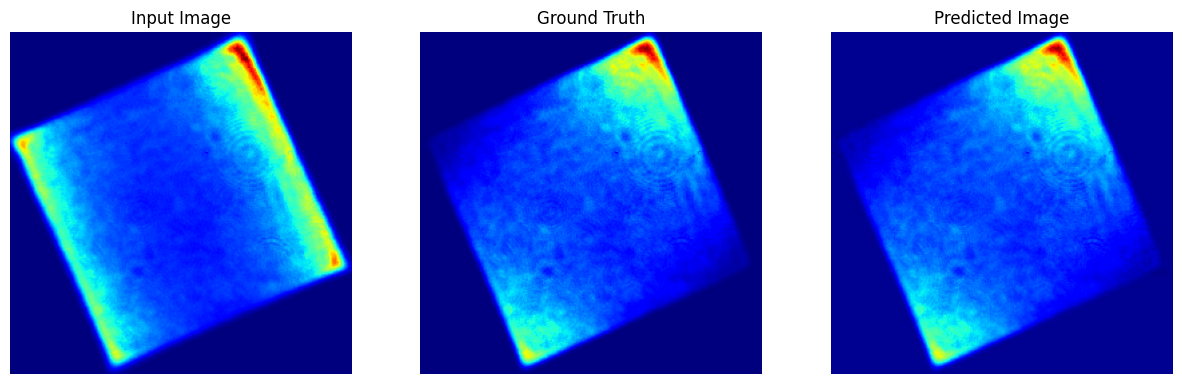

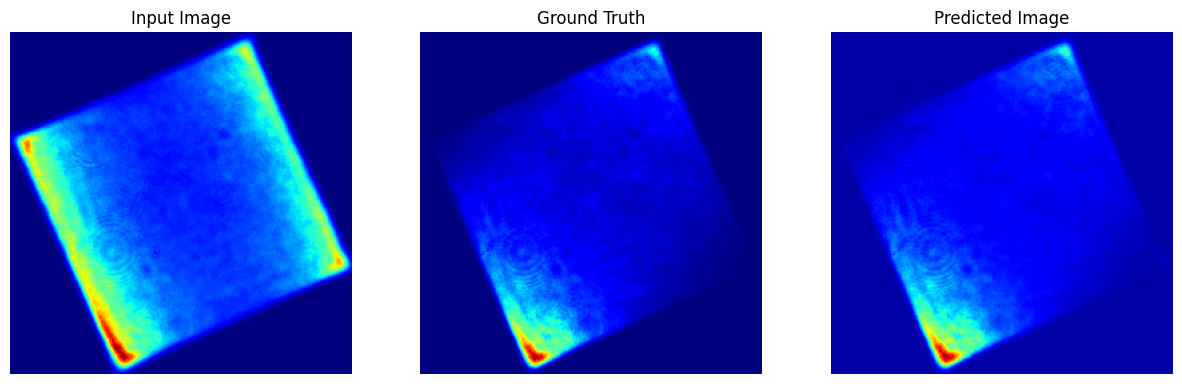

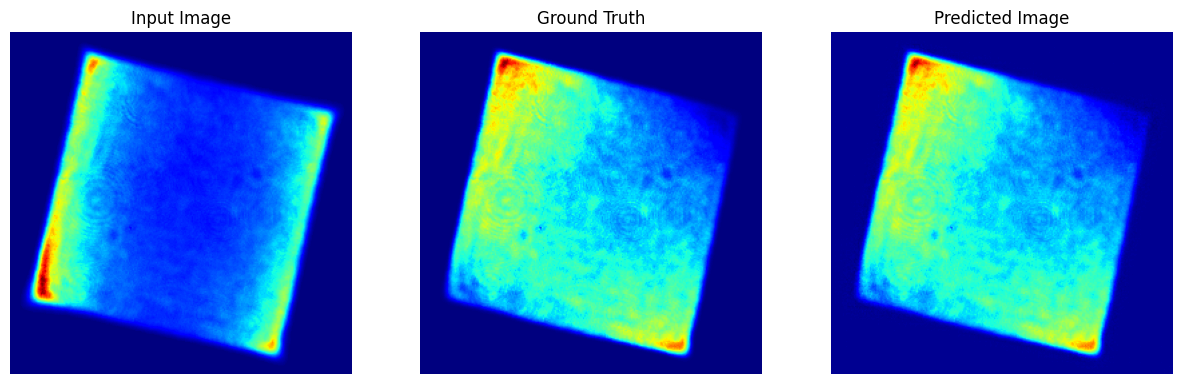

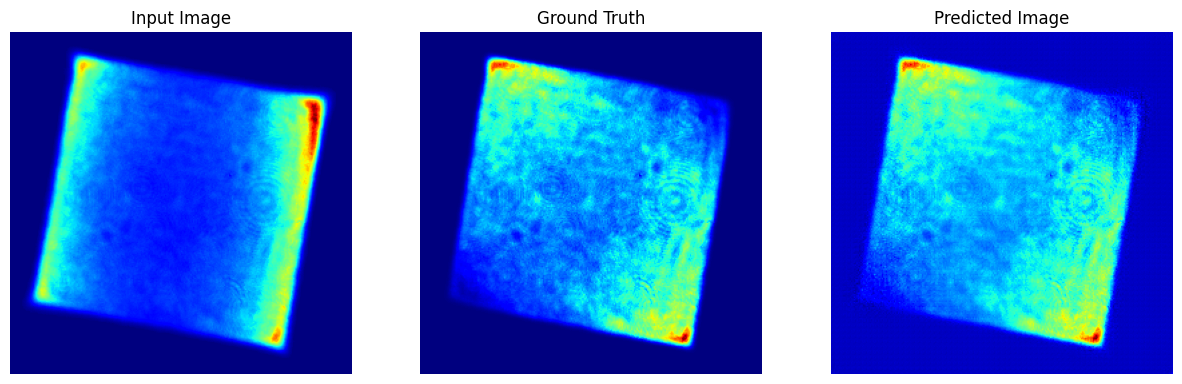

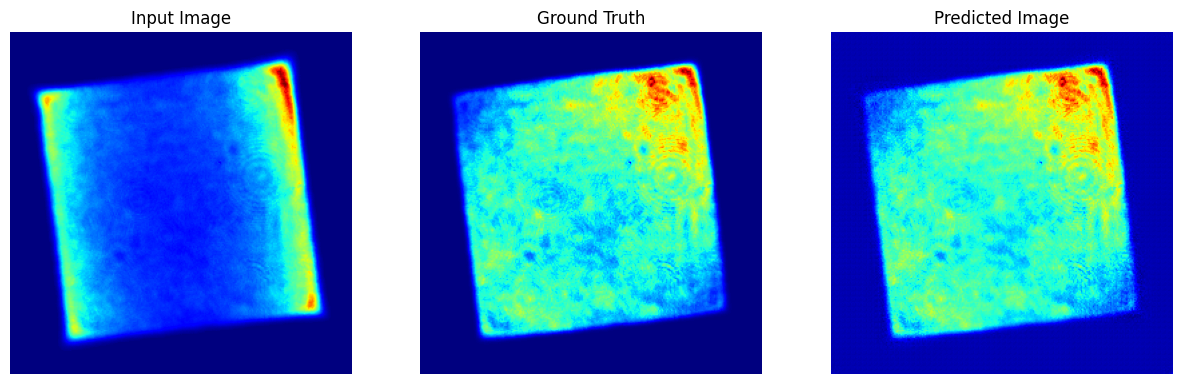

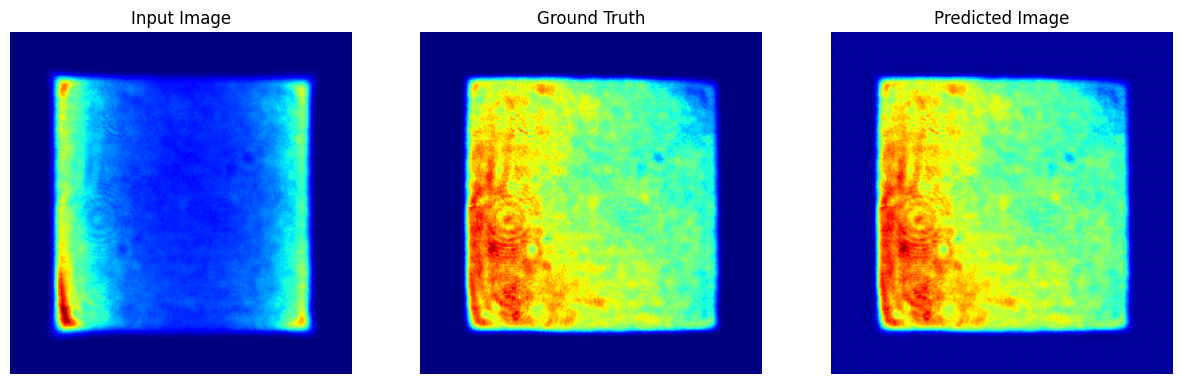

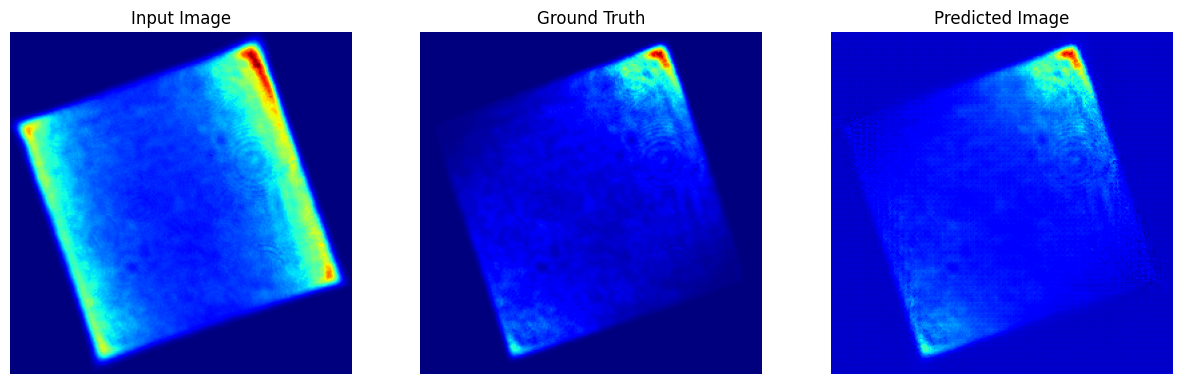

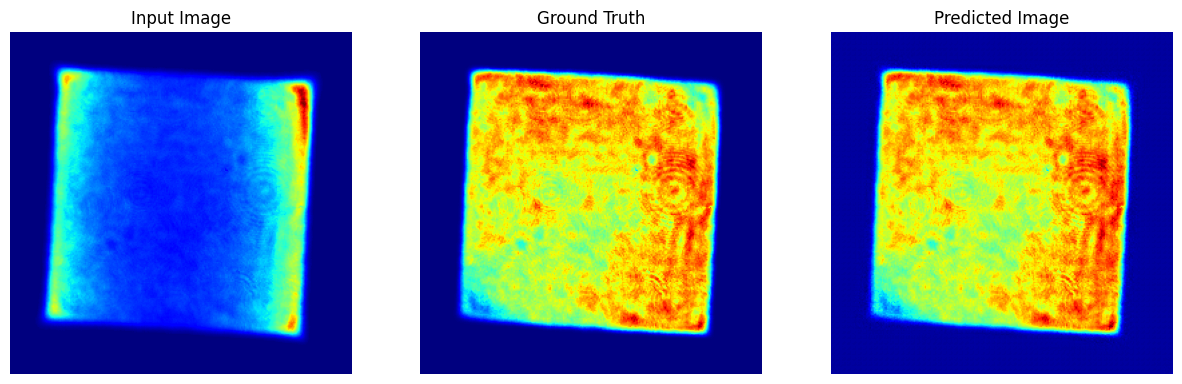

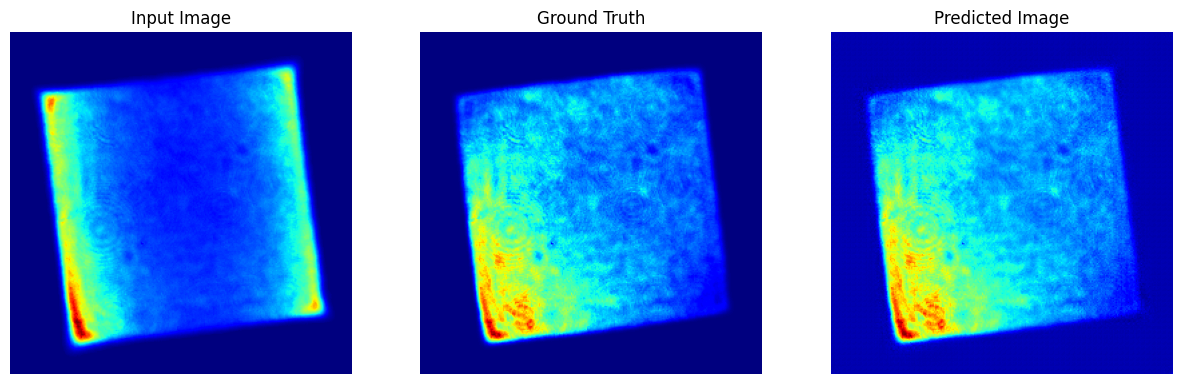

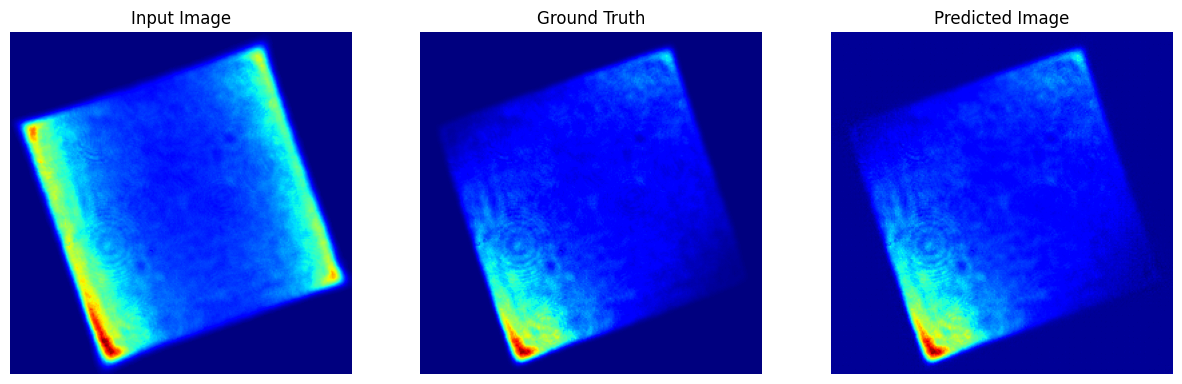

In [28]:
# show first 10 images of train and test

for i in range(10):
    generate_images(X_train_nmp[i], y_train_nmp[i], output_train_nmp[i])
    

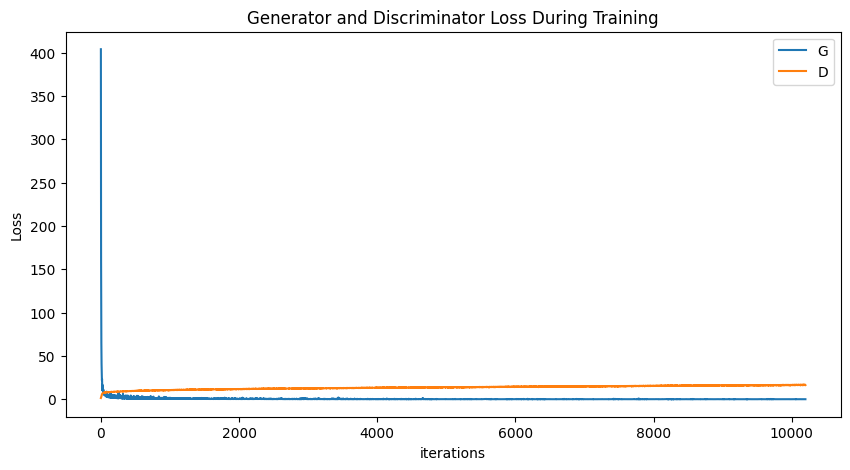

In [29]:
# plot the loss
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="G")
plt.plot(disc_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
